# Predicting birthrate based on human development indicators

In [1]:
#import libraries
import pandas as pd
import re #regular expressions
import statistics as st
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline 
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from scipy import stats


In [2]:
data1 = pd.read_csv('part1.csv')
pd.set_option('display.max_columns', None)


data2 = pd.read_csv('part2.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 264)

data = data1.merge(data2)

In [3]:
data.shape

(2651, 198)

In [4]:
#rename dependent variable
data.rename(columns = {"Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]": "Birth"}, inplace = True)

#move dependant variable to the beginning of the columns
temp = data.pop('Birth')
data.insert(4, 'Birth', temp)

#rename missing values
data.replace("..", np.nan, inplace = True)
data.dropna(subset = ['Country Name'],inplace = True)


In [5]:
#group by countries to study missing values
countries = data.groupby('Country Name')

lst_countries= []
lst_count = []
for country in data['Country Name'].unique():
    temp = countries.get_group(country)
    count = temp.isnull().sum().sum()
    lst_countries.append(country)
    lst_count.append(count)
    

In [6]:
# create a df to show missing values per country
country_df = pd.DataFrame(list(zip(lst_countries, lst_count)), columns = ['Country' , 'Missing'])
country_df.sort_values(by= 'Missing', ascending = False, inplace = True)

In [7]:
country_df.head(20)

,Country,Missing
250,Not classified,1940
183,St. Martin (French part),1869
94,Isle of Man,1854
146,Northern Mariana Islands,1822
3,American Samoa,1802
75,Gibraltar,1795
65,Faroe Islands,1768
39,Channel Islands,1755
200,Turks and Caicos Islands,1753
69,French Polynesia,1748


In [8]:
# Change object types to float
data.iloc[:,4:len(data.columns)] = data.iloc[:,4:len(data.columns)].astype('float64')

    

# Selecting the base year for modelling
based on total missing data  and dependant var missing data


In [9]:
#total missing values per year
time = data.groupby('Time')

for i in range(2011, 2020):
    temp = time.get_group("{}".format(i))
    missing_data = temp.isnull().sum().sum()
    print(i, missing_data)
  

2011 26868
2012 26428
2013 27203
2014 26508
2015 26330
2016 26835
2017 28771
2018 32259
2019 40524


In [10]:
#dependent var missing values per year
for i in range(2011, 2020):
    temp = time.get_group("{}".format(i))
    missing_data = temp['Birth'].isnull().sum()
    print(i, missing_data)
# I've selected 2016 as the base year with low missing values in dependent and independant variables

2011 13
2012 13
2013 14
2014 11
2015 14
2016 13
2017 13
2018 13
2019 264


# Dealing with missing data


In [11]:
# Number of rows and columns at the start
data.shape

(2640, 198)

In [12]:
#max number NaN 198*10 = 1980 | 15% = 297 = 1683
#drop all countries with 85% or more missing values

for country in data['Country Name'].unique():
    if countries.get_group(country).isnull().sum().sum() > 1683:
        data = data[data['Country Name'] != country]




In [13]:
data.shape

(2470, 198)

In [14]:
#fill NaN with data from other years
#Create dataframes for other years to fill NaN with
t2014 = data.groupby('Time').get_group('2014')
t2015 = data.groupby('Time').get_group('2015')

df = data.groupby('Time').get_group('2016')

t2017 = data.groupby('Time').get_group('2017')
t2018 = data.groupby('Time').get_group('2018')

df.reset_index(drop=True, inplace=True)
t2014.reset_index(drop=True, inplace=True)
t2015.reset_index(drop=True, inplace=True)
t2017.reset_index(drop=True, inplace=True)
t2018.reset_index(drop=True, inplace=True)

In [15]:
#code to automatically copy rows from other years to fill up the 2016 df

droplist = []
dbs = [t2017, t2015, t2018, t2014]
for col in range(5,198):                                     #for every predictor column in df
#    print(df.columns[col])
    if df.iloc[:,col].isnull().sum() >= 124:                 #check is col has more than 50% missing values
        missing_val = []                                    # list to store missing count for dbs 
        missing_db = []
        for db in dbs:
            if db.iloc[:,col].isnull().sum() < 124:          #if the db column has less than 50% Missing   
                missing = df.iloc[:,col].isnull().sum()      #count number of missing values
                missing_val.append(missing)                  #copy db, missing to missing_list
                missing_db.append(db)
        if not missing_val:                             #if missing_list is empty, in other words, there are no better options then 2016 df
            droplist.append(df.columns[col])                 #add column to droplist
        else:
            idx = missing_val.index(min(missing_val))        #look at minimum missing values from list and identify best db
            best_db = missing_db[idx]
            df.iloc[:,col] = np.where(True, best_db.iloc[:,col], best_db.iloc[:,col])

C:\Users\eddia\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [16]:
df.reset_index(drop=True, inplace=True)

# delete aggregate areas rows
df.drop(df.index[201:],  inplace = True)


C:\Users\eddia\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
# check total NaN
df.isnull().sum().sum()

18465

In [18]:
#drop all columns with 50% missing values
df = df.drop(droplist, axis = 1)
df.isnull().sum().sum()

4799

In [19]:
df.shape

(201, 112)

In [20]:
#drop some extra values based on on studying these variables
droplist2 = []
for col in range(5,112):
    if df.iloc[:, col].isnull().sum() > 115:
        droplist2.append(df.columns[col])
df = df.drop(droplist2, axis = 1)

In [21]:
#check total missing values
df.isnull().sum().sum()

3977

In [22]:
df.head()

,Time,Time Code,Country Name,Country Code,Birth,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD],"Adjusted net savings, excluding particulate emission damage (% of GNI) [NY.ADJ.SVNX.GN.ZS]",Adjusted savings: education expenditure (% of GNI) [NY.ADJ.AEDU.GN.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]","Foreign direct investment, net outflows (% of GDP) [BM.KLT.DINV.WD.GD.ZS]",GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],GNI per capita (constant 2010 US$) [NY.GNP.PCAP.KD],Gross capital formation (% of GDP) [NE.GDI.TOTL.ZS],Gross capital formation (constant 2010 US$) [NE.GDI.TOTL.KD],Gross national expenditure (% of GDP) [NE.DAB.TOTL.ZS],Gross savings (% of GDP) [NY.GNS.ICTR.ZS],Gross savings (% of GNI) [NY.GNS.ICTR.GN.ZS],Households and NPISHs Final consumption expenditure (annual % growth) [NE.CON.PRVT.KD.ZG],Households and NPISHs Final consumption expenditure (constant 2010 US$) [NE.CON.PRVT.KD],Households and NPISHs Final consumption expenditure per capita (constant 2010 US$) [NE.CON.PRVT.PC.KD],"Industry (including construction), value added (% of GDP) [NV.IND.TOTL.ZS]","Industry (including construction), value added per worker (constant 2010 US$) [NV.IND.EMPL.KD]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]","Manufacturing, value added (constant 2010 US$) [NV.IND.MANF.KD]",Net official development assistance and official aid received (constant 2015 US$) [DT.ODA.ALLD.KD],Trade (% of GDP) [NE.TRD.GNFS.ZS],"Adjusted net enrollment rate, primary (% of primary school age children) [SE.PRM.TENR]","Adjusted net enrollment rate, primary, female (% of primary school age children) [SE.PRM.TENR.FE]","Adjusted net enrollment rate, primary, male (% of primary school age children) [SE.PRM.TENR.MA]",Adolescents out of school (% of lower secondary school age) [SE.SEC.UNER.LO.ZS],Children out of school (% of primary school age) [SE.PRM.UNER.ZS],"Compulsory education, duration (years) [SE.COM.DURS]","Gross intake ratio in first grade of primary education, female (% of relevant age group) [SE.PRM.GINT.FE.ZS]","Gross intake ratio in first grade of primary education, male (% of relevant age group) [SE.PRM.GINT.MA.ZS]","Gross intake ratio in first grade of primary education, total (% of relevant age group) [SE.PRM.GINT.ZS]","Lower secondary completion rate, female (% of relevant age group) [SE.SEC.CMPT.LO.FE.ZS]","Lower secondary completion rate, male (% of relevant age group) [SE.SEC.CMPT.LO.MA.ZS]","Lower secondary completion rate, total (% of relevant age group) [SE.SEC.CMPT.LO.ZS]","Persistence to last grade of primary, female (% of cohort) [SE.PRM.PRSL.FE.ZS]","Persistence to last grade of primary, male (% of cohort) [SE.PRM.PRSL.MA.ZS]","Persistence to last grade of primary, total (% of cohort) [SE.PRM.PRSL.ZS]","Preprimary education, duration (years) [SE.PRE.DURS]","Primary completion rate, female (% of relevant age group) [SE.PRM.CMPT.FE.ZS]","Primary completion rate, male (% of relevant age group) [SE.PRM.CMPT.MA.ZS]","Primary completion rate, total (% of relevant age group) [SE.PRM.CMPT.ZS]","Primary education, duration (years) [SE.PRM.DURS]",Progression to secondary school (%) [SE.SEC.PROG.ZS],"Progression to secondary school, female (%) [SE.SEC.PROG.FE.ZS]","Progression to secondary school, male (%) [SE.SEC.PROG.MA.ZS]",Access to electricity (% of population) [EG.ELC.ACCS.ZS],Agricultural land (% of land area) [AG.LND.AGRI.ZS],Average precipitation in depth (mm per year) [AG.LND.PRCP.MM],CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC],Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC],Energy use (kg of oil equivalent per capita) [EG.USE.PCAP.KG.OE],Population in the largest city (% of urban population) [EN.URB.LCTY.UR.ZS],Population in urban agglomerations of more than 1 million (% of total population) [EN.U

In [23]:
#drop variables that are almost identical to the target variable
# https://data.worldbank.org/indicator/SP.POP.DPND
df = df.drop(['Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]', 'Age dependency ratio (% of working-age population) [SP.POP.DPND]'], axis = 1)

# Detect and remove outliers


In [24]:
columns_outliers = ['Adjusted net savings, excluding particulate emission damage (% of GNI) [NY.ADJ.SVNX.GN.ZS]',
           'Adjusted savings: education expenditure (% of GNI) [NY.ADJ.AEDU.GN.ZS]', 
           'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
           'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
                    'GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
                     'GNI per capita (constant 2010 US$) [NY.GNP.PCAP.KD]',
                    'Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC]',
                    'Population in urban agglomerations of more than 1 million (% of total population) [EN.URB.MCTY.TL.ZS]',
                    'Consumer price index (2010 = 100) [FP.CPI.TOTL]',
                    'Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]',
                    'Cause of death, by injury (% of total) [SH.DTH.INJR.ZS]',
                    
                    
                    ]
                
                    

103   -67.775153
Name: Adjusted net savings, excluding particulate emission damage (% of GNI) [NY.ADJ.SVNX.GN.ZS], dtype: float64
119    23.62883
Name: Adjusted savings: education expenditure (% of GNI) [NY.ADJ.AEDU.GN.ZS], dtype: float64
78     187.017143
107    213.035693
152    173.068169
Name: Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS], dtype: float64
105    972.699461
Name: Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS], dtype: float64
107    110162.121623
Name: GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD], dtype: float64
135    93958.628707
Name: GNI per capita (constant 2010 US$) [NY.GNP.PCAP.KD], dtype: float64
80    53832.479092
Name: Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC], dtype: float64
78      99.539882
159    100.000000
Name: Population in urban agglomerations of more than 1 million (% of total population) [EN.URB.MCTY.TL.ZS], dtype: float64
165    1592.384775
195    2740.273985
Name: Consumer price i

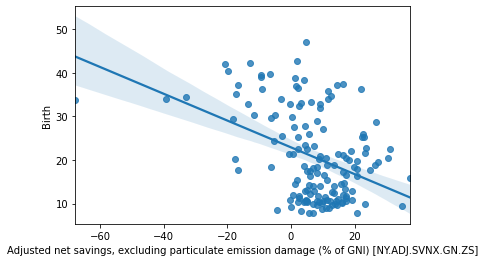

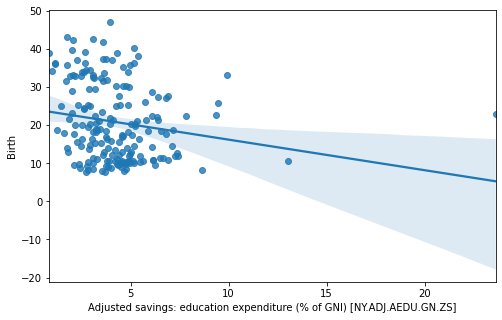

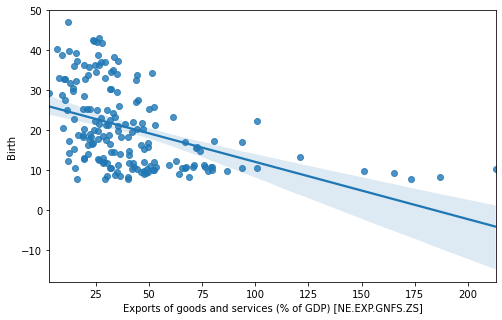

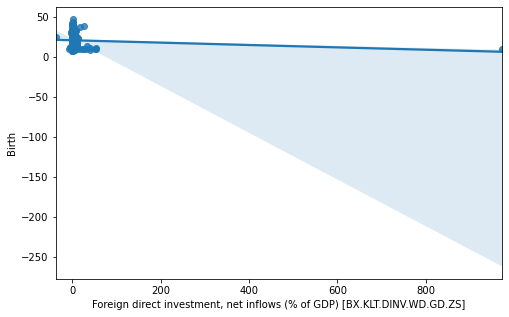

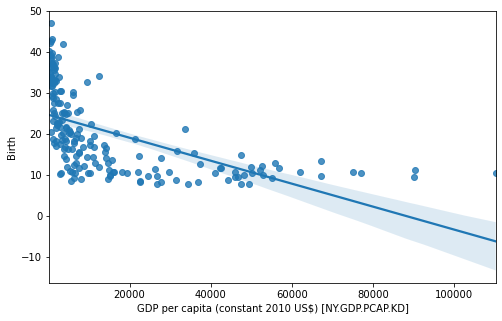

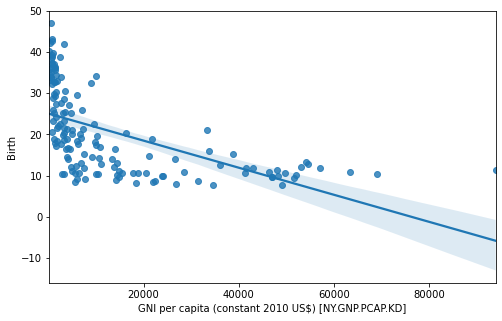

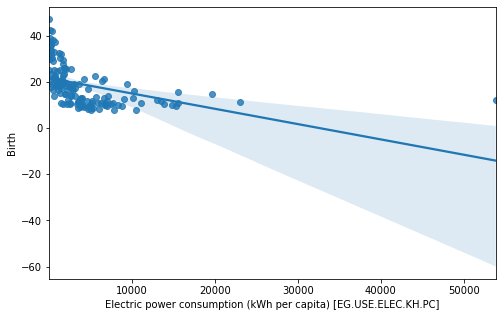

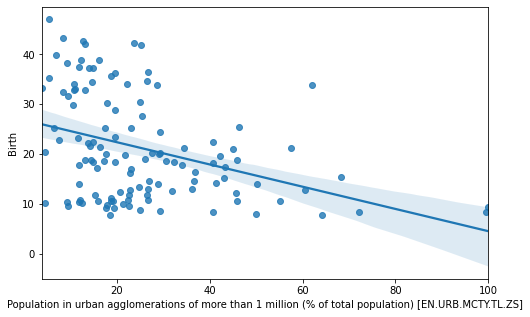

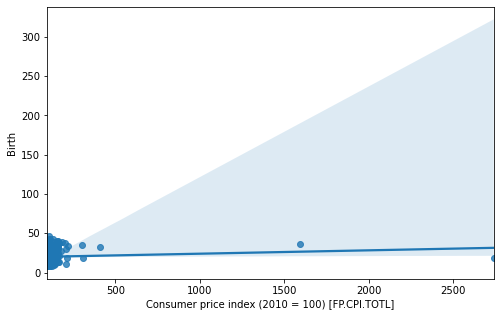

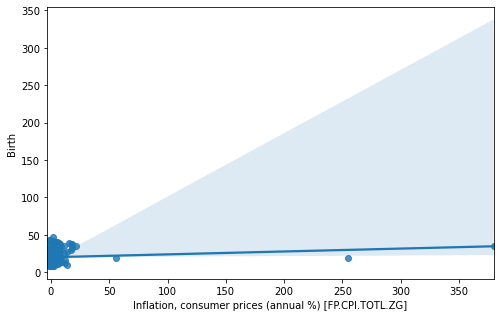

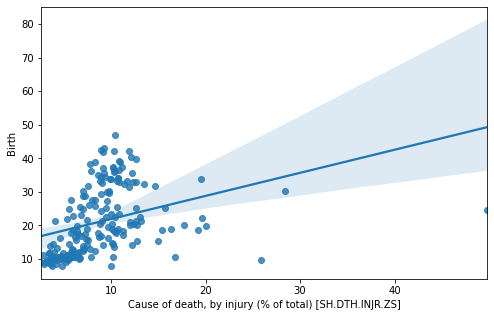

<Figure size 576x360 with 0 Axes>

In [25]:
#check if 4 std captures the outliers well
for col in columns_outliers:
    upper_limit = df[col].mean() + 4 * df[col].std()
    lower_limit = df[col].mean() - 4 * df[col].std()
    outliers = df[col][(df[col] < lower_limit) | (df[col] > upper_limit)]
    print(outliers)
    ax = sns.regplot(x= col, y="Birth", data=df)
    plt.figure(figsize=(8,5))
    

In [26]:
# number missing
df.isnull().sum().sum()

3954

In [27]:
#replace outliers with NaN
for col in columns_outliers:
    upper_limit = df[col].mean() + 4 * df[col].std()
    lower_limit = df[col].mean() - 4 * df[col].std()
    condition = (df[col] < lower_limit) | (df[col] > upper_limit)
    df[col] = np.where(condition, np.nan, df[col])

In [28]:
df.isnull().sum().sum()

3970

In [29]:
# repeat outlier deletion for new outliers

for col in columns_outliers:
    upper_limit = df[col].mean() + 4 * df[col].std()
    lower_limit = df[col].mean() - 4 * df[col].std()
    condition = (df[col] < lower_limit) | (df[col] > upper_limit)
    df[col] = np.where(condition, np.nan, df[col])

In [30]:
df.isnull().sum().sum()

3984

# Feature Selection

In [31]:
#show pairwise correlations
top = abs(df.iloc[:,5:].corr().unstack().sort_values().drop_duplicates())

top[top > 0.7]

Urban population (% of total population) [SP.URB.TOTL.IN.ZS]                     Rural population (% of total population) [SP.RUR.TOTL.ZS]                                                                 1.000000
Cause of death, by non-communicable diseases (% of total) [SH.DTH.NCOM.ZS]       Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total) [SH.DTH.COMM.ZS]    0.974423
Children out of school (% of primary school age) [SE.PRM.UNER.ZS]                Adjusted net enrollment rate, primary (% of primary school age children) [SE.PRM.TENR]                                    0.961345
Mortality rate, adult, female (per 1,000 female adults) [SP.DYN.AMRT.FE]         Life expectancy at birth, total (years) [SP.DYN.LE00.IN]                                                                  0.951198
                                                                                 Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]           

In [32]:
df.drop(['Time', 'Time Code'], axis = 1, inplace =True)

# drop pairwise correlations

In [33]:
pairwise = ['GNI per capita (constant 2010 US$) [NY.GNP.PCAP.KD]', 
            'Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]',
           'Persistence to last grade of primary, male (% of cohort) [SE.PRM.PRSL.MA.ZS]',
           'Persistence to last grade of primary, female (% of cohort) [SE.PRM.PRSL.FE.ZS]',
           'Number of infant deaths [SH.DTH.IMRT]',
            'Number of under-five deaths [SH.DTH.MORT]',
            'Life expectancy at birth, male (years) [SP.DYN.LE00.MA.IN]',
            'Life expectancy at birth, total (years) [SP.DYN.LE00.IN]',
            'Lower secondary completion rate, total (% of relevant age group) [SE.SEC.CMPT.LO.ZS]',
            'Lower secondary completion rate, male (% of relevant age group) [SE.SEC.CMPT.LO.MA.ZS]',
            'Employers, total (% of total employment) (modeled ILO estimate) [SL.EMP.MPYR.ZS]',
            'Gross intake ratio in first grade of primary education, female (% of relevant age group) [SE.PRM.GINT.FE.ZS]',
            'Gross intake ratio in first grade of primary education, total (% of relevant age group) [SE.PRM.GINT.ZS]',
            'Ratio of female to male labor force participation rate (%) (national estimate) [SL.TLF.CACT.FM.NE.ZS]',
            'Primary completion rate, female (% of relevant age group) [SE.PRM.CMPT.FE.ZS]',
            'Primary completion rate, male (% of relevant age group) [SE.PRM.CMPT.MA.ZS]',
            'Progression to secondary school (%) [SE.SEC.PROG.ZS]',
            'Progression to secondary school, male (%) [SE.SEC.PROG.MA.ZS]',
            'Primary completion rate, total (% of relevant age group) [SE.PRM.CMPT.ZS]',
            'Gross savings (% of GDP) [NY.GNS.ICTR.ZS]',
            'Households and NPISHs Final consumption expenditure per capita (constant 2010 US$) [NE.CON.PRVT.PC.KD]',
            'Gross capital formation (constant 2010 US$) [NE.GDI.TOTL.KD]',
            'Adjusted net enrollment rate, primary, male (% of primary school age children) [SE.PRM.TENR.MA]',
            'Adjusted net enrollment rate, primary (% of primary school age children) [SE.PRM.TENR]',
            'Labor force, female (% of total labor force) [SL.TLF.TOTL.FE.ZS]',
            'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total) [SH.DTH.COMM.ZS]',
            'Trade (% of GDP) [NE.TRD.GNFS.ZS]',
            'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]',
            'Mortality rate, adult, female (per 1,000 female adults) [SP.DYN.AMRT.FE]',
            'Mortality rate, neonatal (per 1,000 live births) [SH.DYN.NMRT]',
            
            'Mortality rate, under-5 (per 1,000 live births) [SH.DYN.MORT]',
            'UHC service coverage index [SH.UHC.SRVS.CV.XD]',
            'People using at least basic sanitation services (% of population) [SH.STA.BASS.ZS]',
            'Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL]',
            'Lifetime risk of maternal death (%) [SH.MMR.RISK.ZS]',
            'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
            'Access to electricity (% of population) [EG.ELC.ACCS.ZS]',
            'Households and NPISHs Final consumption expenditure (constant 2010 US$) [NE.CON.PRVT.KD]',
                  
           'Cause of death, by non-communicable diseases (% of total) [SH.DTH.NCOM.ZS]',
           'People using at least basic drinking water services (% of population) [SH.H2O.BASW.ZS]',
           
            'Adolescents out of school (% of lower secondary school age) [SE.SEC.UNER.LO.ZS]',
            'Persistence to last grade of primary, total (% of cohort) [SE.PRM.PRSL.ZS]',
            
            
           ]

In [34]:
#drop pairwise correlations
for col in pairwise:
    df.drop(columns = col, inplace = True)
    #print(col)
    #x_data = df[df.columns[3:len(df.columns)]]
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.23, random_state = 2)
    #lm.fit(x_train,y_train) 
    #print(lm.score(x_test,y_test))

In [35]:
#check correlation with the target
#var1 = 'Adolescents out of school (% of lower secondary school age) [SE.SEC.UNER.LO.ZS]'

#df['Birth'].corr(df[var1])

In [36]:
#check correlation with the target
#var2 = 'Lower secondary completion rate, female (% of relevant age group) [SE.SEC.CMPT.LO.FE.ZS]'

#df['Birth'].corr(df[var2])

In [37]:
#check correlation with the target
#var3 = 'Persistence to last grade of primary, total (% of cohort) [SE.PRM.PRSL.ZS]'

#df['Birth'].corr(df[var3])

In [38]:
#check correlation with the target
#var3 = 'Persistence to last grade of primary, total (% of cohort) [SE.PRM.PRSL.ZS]'

#df['Adolescents out of school (% of lower secondary school age) [SE.SEC.UNER.LO.ZS]'].corr(df[var3])

# Drop low corr with target

In [39]:
corr = abs(df.corr().iloc[:,0]).sort_values()

selection = corr[corr < 0.5]

for i in range(0,len(selection)):
    df.drop(columns = selection.index[i], inplace = True)
    #print(selection.index[i])
    #x_data = df[df.columns[3:len(df.columns)]]
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.23, random_state = 2)
    #lm.fit(x_train,y_train) 
    #print(lm.score(x_test,y_test))

In [40]:
#show corr with target
abs(df.corr().iloc[:,0]).sort_values()

Current health expenditure per capita, PPP (current international $) [SH.XPD.CHEX.PP.CD]             0.522814
Hospital beds (per 1,000 people) [SH.MED.BEDS.ZS]                                                    0.543584
Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC]                                      0.565394
Rural population (% of total population) [SP.RUR.TOTL.ZS]                                            0.566318
Children out of school (% of primary school age) [SE.PRM.UNER.ZS]                                    0.576631
GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]                                                  0.582231
Progression to secondary school, female (%) [SE.SEC.PROG.FE.ZS]                                      0.638966
People practicing open defecation (% of population) [SH.STA.ODFC.ZS]                                 0.644294
Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]                        0.646895
Adjusted n

# Data Visualisation

Text(0.5, 1.0, 'Boxplot')

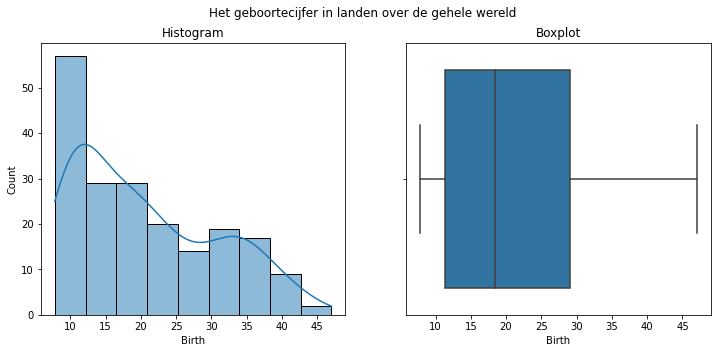

In [41]:
# outcome variable
fig, axes = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Het geboortecijfer in landen over de gehele wereld ')

sns.histplot(ax = axes[0] , data=df, x= 'Birth' , kde=True)
axes[0].set_title('Histogram')
sns.boxplot(ax = axes[1] ,data=df, x= 'Birth')
axes[1].set_title('Boxplot')

Text(0, 0.5, 'Geboorecijfer')

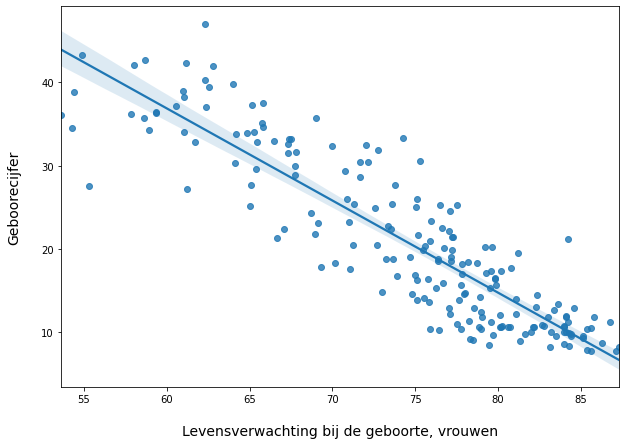

In [42]:
plt.figure(figsize=(10,7))
ax = sns.regplot(x= 'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]', y="Birth", data=df)
plt.xlabel('Levensverwachting bij de geboorte, vrouwen', fontdict= {'fontsize': 14}, labelpad = 20)
plt.ylabel('Geboorecijfer', fontdict= {'fontsize': 14}, labelpad = 20)



# Transforming the predictor variables

Text(0.5, 1.0, 'Reciprocal')

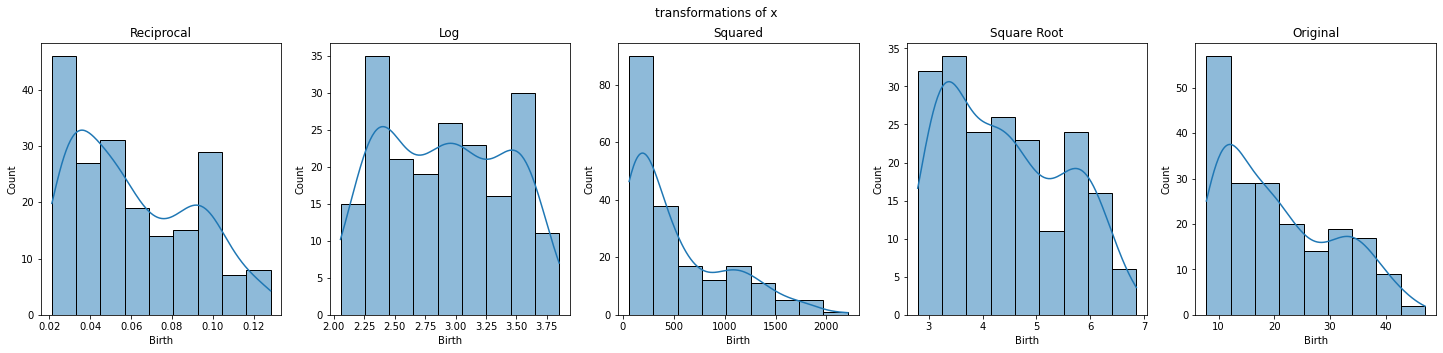

In [43]:
# outcome variable
fig, axes = plt.subplots(1, 5, figsize=(25,5))
fig.suptitle('transformations of x')

sns.histplot(ax = axes[4] , data=df, x= 'Birth' , kde=True)
axes[4].set_title('Original')
sns.histplot(ax = axes[3] ,data=df, x= df['Birth'].transform(np.sqrt) , kde=True)
axes[3].set_title('Square Root')
sns.histplot(ax = axes[2] ,data=df, x= df['Birth'] ** 2 , kde=True)
axes[2].set_title('Squared')
sns.histplot(ax = axes[1] ,data=df, x= df['Birth'].transform(np.log) , kde=True)
axes[1].set_title('Log')
sns.histplot(ax = axes[0] ,data=df, x= df['Birth'].transform(np.reciprocal) , kde=True)
axes[0].set_title('Reciprocal')

In [44]:
log_transform = ['Birth',
                'GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
                'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
                 'Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC]',
                 'Current health expenditure per capita, PPP (current international $) [SH.XPD.CHEX.PP.CD]',
                'Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]']

sqrt_transform = ['Population living in slums (% of urban population) [EN.POP.SLUM.UR.ZS]',
                 'Depositors with commercial banks (per 1,000 adults) [FB.CBK.DPTR.P3]',
                 'Hospital beds (per 1,000 people) [SH.MED.BEDS.ZS]',
                 'People practicing open defecation (% of population) [SH.STA.ODFC.ZS]',
                 'Physicians (per 1,000 people) [SH.MED.PHYS.ZS]']

original = ['Adjusted net enrollment rate, primary, female (% of primary school age children) [SE.PRM.TENR.FE]',
           'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
           'Compulsory education, duration (years) [SE.COM.DURS]',
           'Lower secondary completion rate, female (% of relevant age group) [SE.SEC.CMPT.LO.FE.ZS]',
           'Persistence to last grade of primary, total (% of cohort) [SE.PRM.PRSL.ZS]',
           'Progression to secondary school, female (%) [SE.SEC.PROG.FE.ZS]',
            'Rural population (% of total population) [SP.RUR.TOTL.ZS]',
            'Ease of doing business score (0 = lowest performance to 100 = best performance) [IC.BUS.DFRN.XQ]']     

squared_transform = ['Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]']

     
    

In [45]:
dft = df

In [46]:
# transform columns
dft[log_transform] = dft[log_transform].transform(np.log)
dft[sqrt_transform] = dft[sqrt_transform].transform(np.sqrt)
dft[squared_transform] = dft[squared_transform] ** 2

# Fill NaN

In [47]:
#fill all NaN values with the mean for each column
for col in range(3, len(dft.columns)):
    mean = dft[dft.columns[col]].mean()
    dft[dft.columns[col]].fillna(mean, inplace= True)


In [48]:
dft.isnull().sum().sum()

5

In [49]:
#drop countries where outcome variable = birthrate is missing
dft.dropna(axis = 0, inplace= True)

# Modelling

# Vanilla model


In [50]:
lm = LinearRegression()
x_data = dft[dft.columns[3:len(dft.columns)]]
y_data = dft['Birth']

In [51]:
#split data in 2 sets

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.28, random_state = 10)

#vanilla model
lm.fit(x_train,y_train) 
score = lm.score(x_test,y_test)

In [52]:
dft.shape

(196, 19)

# Recursive feature elimination

In [53]:
selector = RFECV(lm, step=1, cv=5).fit(x_train, y_train)


In [54]:
selector.grid_scores_

array([0.56324608, 0.57070951, 0.63342676, 0.68361665, 0.71058785,
       0.70587668, 0.70966572, 0.72442243, 0.72381242, 0.73690392,
       0.7446889 , 0.747754  , 0.74945009, 0.74635268, 0.76168023,
       0.79649067])

In [55]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

## SequentialFeatureSelector

In [57]:
#forward selection - Linear regression - transformed data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.28, random_state = 10)
mlsfs = SFS(lm, k_features = (1,3) , floating = True, forward=True)
mlsfs.fit(x_train, y_train)
mlsfs.subsets_[3]

{'feature_idx': (0, 2, 12),
 'cv_scores': array([0.86144137, 0.76501489, 0.80140032, 0.77929531, 0.83083601]),
 'avg_score': 0.8075975797469068,
 'feature_names': ('GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
  'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
  'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')}

In [58]:
#backward selection
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.28, random_state = 10)
mlsbs = SFS(lm, floating = True, forward=False)
mlsbs.fit(x_train, y_train)
mlsbs.subsets_[3]

{'feature_idx': (0, 2, 12),
 'cv_scores': array([0.86144137, 0.76501489, 0.80140032, 0.77929531, 0.83083601]),
 'avg_score': 0.8075975797469068,
 'feature_names': ('GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
  'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
  'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')}

In [59]:
#Lasso regression
lasso = linear_model.Lasso(alpha=1)
lasso.fit(x_train, y_train)
lasso.score(x_test, y_test)

0.622310759906231

In [60]:
# Random forest resgression
from sklearn.ensemble import RandomForestRegressor
for max_leaf_nodes in [2,5,10,15,20,25,30,40,45,50,60,70,80,90,100]:
    rf = RandomForestRegressor(random_state=4, max_leaf_nodes= max_leaf_nodes )
    rf.fit(x_train, y_train)
    score = rf.score(x_test, y_test)
    print(f'leaves: {max_leaf_nodes} \t score:{score}')

leaves: 2 	 score:0.5980112995668428
leaves: 5 	 score:0.7908138902072207
leaves: 10 	 score:0.8319842182877398
leaves: 15 	 score:0.8330847169848262
leaves: 20 	 score:0.8381067613615061
leaves: 25 	 score:0.8416274560743532
leaves: 30 	 score:0.8424849131709287
leaves: 40 	 score:0.8437171864195667
leaves: 45 	 score:0.8441126719090186
leaves: 50 	 score:0.8445997270065722
leaves: 60 	 score:0.8448085238863343
leaves: 70 	 score:0.8445039778837639
leaves: 80 	 score:0.8444786759967338
leaves: 90 	 score:0.8444335467328717
leaves: 100 	 score:0.8444443433502593


In [61]:
#forward selection - random forest
rf = RandomForestRegressor(random_state=4, max_leaf_nodes= 45 )
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.28, random_state = 10)
mlsfs = SFS(rf, k_features = (1,16) , floating = True, forward=True)
mlsfs.fit(x_train, y_train)
mlsfs.subsets_

{1: {'feature_idx': (12,),
  'cv_scores': array([0.76848024, 0.70450272, 0.76430266, 0.75200543, 0.69094982]),
  'avg_score': 0.7360481724646035,
  'feature_names': ('Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]',)},
 2: {'feature_idx': (11, 12),
  'cv_scores': array([0.76883252, 0.75053203, 0.79207113, 0.80117575, 0.84445674]),
  'avg_score': 0.7914136346895028,
  'feature_names': ('Hospital beds (per 1,000 people) [SH.MED.BEDS.ZS]',
   'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')},
 3: {'feature_idx': (2, 11, 12),
  'cv_scores': array([0.83625471, 0.79970178, 0.80837159, 0.82140458, 0.84721051]),
  'avg_score': 0.8225886351542158,
  'feature_names': ('Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
   'Hospital beds (per 1,000 people) [SH.MED.BEDS.ZS]',
   'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')},
 4: {'feature_idx': (2, 6, 11, 12),
  'cv_scores': array([0.83636827, 0.79933041, 0.81467874, 0.81797596, 0.86

In [62]:
score_list = []
for i in range(len(mlsfs.subsets_)):
    score = mlsfs.subsets_[i+1]['avg_score']
    score_list.append(score)

Text(0.5, 1.0, 'Random Forest Regression Model')

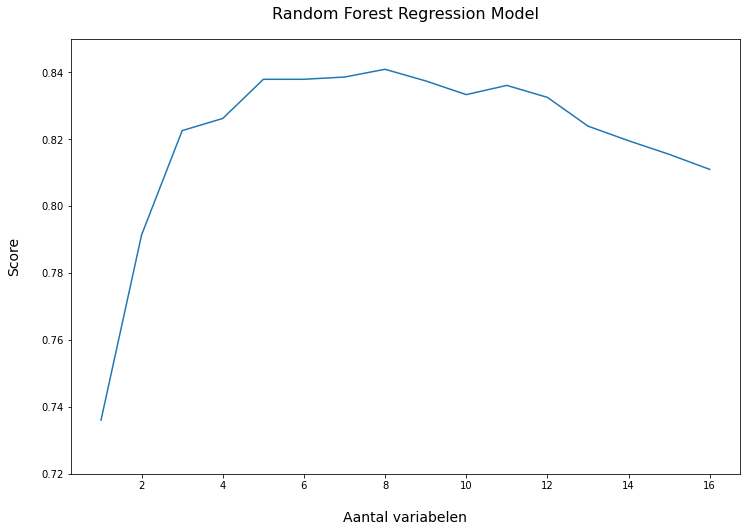

In [63]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(y = score_list , x=[i+1 for i in range(16)])
# change x-tick
# add labels

ax.set(ylim=(0.72, 0.85))
plt.xlabel('Aantal variabelen', fontdict= {'fontsize': 14}, labelpad = 20)
plt.ylabel('Score', fontdict= {'fontsize': 14}, labelpad = 20)
plt.title('Random Forest Regression Model', fontdict= {'fontsize': 16}, pad = 20 )

In [64]:
#ridge forward selection
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.28, random_state = 10)
ridge = linear_model.Ridge(alpha=0.1)
sfs_ridge = SFS(ridge, k_features = (1,16) , floating = True, forward=True)
sfs_ridge.fit(x_train, y_train)
sfs_ridge.subsets_

{1: {'feature_idx': (12,),
  'cv_scores': array([0.85425094, 0.71340282, 0.72118927, 0.74360095, 0.83287077]),
  'avg_score': 0.7730629482863969,
  'feature_names': ('Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]',)},
 2: {'feature_idx': (0, 12),
  'cv_scores': array([0.87308672, 0.75413652, 0.77582224, 0.76331328, 0.83474431]),
  'avg_score': 0.8002206132925987,
  'feature_names': ('GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
   'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')},
 3: {'feature_idx': (0, 2, 12),
  'cv_scores': array([0.86146748, 0.76501237, 0.80137958, 0.77927729, 0.83087734]),
  'avg_score': 0.8076028118623506,
  'feature_names': ('GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]',
   'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]',
   'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]')},
 4: {'feature_idx': (0, 2, 12, 15),
  'cv_scores': array([0.85403484, 0.75295837, 0.80829253, 0.8039736 , 0.